In [1]:
import time
import os
import datetime
import random
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import haversine as hs
from haversine import Unit
from shapely.geometry import Point, Polygon, LineString
from math import radians, cos, sin, asin, sqrt
from collections import defaultdict

NOT_AVAILABLE_MSG = "No Available Trip in The Given Service Day"



In [2]:
trips_df = pd.read_csv("../../../data/mmt_gtfs/trips.csv")
routes_df = pd.read_csv("../../../data/mmt_gtfs/routes.csv")
stops_df = pd.read_csv("../../../data/bus_route_stop_info/stops.csv")
stops_df = stops_df[stops_df["Route"] != "None"]  # filter stops that are not currently in service
stop_times_df = pd.read_csv("../../../data/mmt_gtfs/stop_times.csv")
city = gpd.read_file("../../../data/plot/background/madison-shp")
water = gpd.read_file("../../../data/plot/background/water-shp")
street = gpd.read_file("../../../data/plot/background/streets-shp")
zones = gpd.read_file("../../../data/plot/background/zoning_districts-shp")
zones = zones.dropna(subset=["ZONING_COD"])

63329.08ms


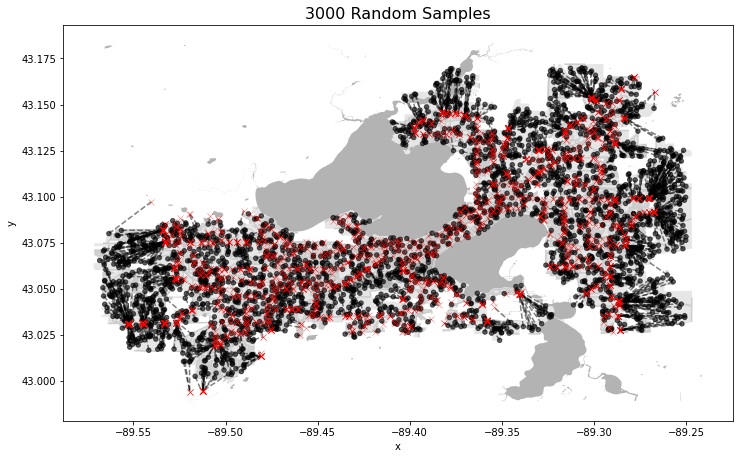

In [3]:
def generate_random(num_points, polygons):
    """
    take as input a numpoints and a list of polygons,
    output a list of points within the given polygons

    :param num_points: number of points generated
    :param polygons: a list of Shapely Polygon
    """
    points = []

    while len(points) < num_points:
        choice = random.choice(range(len(polygons)))
        polygon = polygons[choice]
        minx, miny, maxx, maxy = polygon.bounds
        pnt = Point(random.uniform(round(minx, 2), round(maxx, 2)),
                    random.uniform(round(miny, 2), round(maxy, 2)))
        if polygon.contains(pnt):
            points.append(pnt)
    return points

def plot_random(num_points, ax, **kwargs):
    text_offset = 0.0008
    names = []
    colors = []
    x = []
    y = []
    points = generate_random(num_points, list(city.geometry))
    for idx, p in enumerate(points):

        # randomly generate colors (re-adjust so it's more visibly clear)

        # option 1: generate random colors
        # r = lambda: random.randint(0,255)
        # c = '#%02X%02X%02X' % (r(),r(),r())

        # option 2: all black colors
        c = "k"
        colors.append(c)

        # pt names
        pt_name = "p" + str(idx)
        names.append(pt_name)

        x.append(float(p.x))
        y.append(float(p.y))

        # marking each generated points
        # ax.text(p.x + text_offset, p.y, pt_name, va="bottom", ha="left", c=c)
    df = pd.DataFrame({"name":names, "x":x, "y":y, "color":colors})
    df.plot.scatter("x", "y", ax=ax, c=colors, **kwargs)
    return colors, points


def find_nearest(points):
    """
    Find the nearest bus stops for each point in the points parameter.

    :param points: a list of shapely Point objects
    :return: a DataFrame of columns: stop_id, lon, lat, distance in miles
    """
    ids = []
    lons = []
    lats = []
    dists = []
    for p in points:
        x = p.x
        y = p.y

        # element wise operation to find the smallest value
        euclidean = (stops_df["stop_lon"] - x) ** 2 + (stops_df["stop_lat"] - y) ** 2
        idx = euclidean.idxmin()  # index of the smallest value

        stop_id = stops_df.loc[euclidean.idxmin(), "stop_id"]
        lon = stops_df.loc[euclidean.idxmin(), "stop_lon"]
        lat = stops_df.loc[euclidean.idxmin(), "stop_lat"]
        dist = hs.haversine((x, y), (lon, lat), unit=Unit.MILES)  # in miles
        dist = dist * 1609.34  # in meters

        ids.append(stop_id)
        lons.append(lon)
        lats.append(lat)
        dists.append(dist)
    stops = pd.DataFrame({
        "stop_id": ids,
        "stop_lon": lons,
        "stop_lat": lats,
        "pt_lon": [p.x for p in points],
        "pt_lat": [p.y for p in points],
        "distance (in meters)": dists
    })
    return stops

def connect_to_stops(ax, points, stops):
    """
    Draw a line from randomly generated points to nearest bus stops that are in service.

    :param stops: stops dataframe that have columns stop_id, lat, lon, dist
    :param ax: Axes object to plot
    :return: None
    """
    linestrings = []
    for idx, row in stops.iterrows():
        ls = LineString([(points[idx].x, points[idx].y), (row["stop_lon"], row["stop_lat"])])
        linestrings.append(ls)

    df = pd.DataFrame({"geometry":linestrings})
    df.set_geometry("geometry").plot(ax=ax, color="k", linestyle="--", alpha=0.5)

def minute_wait(stops, t, serv):
    """

    :param stops:
    :return:
    """

    # service type
    serv_types = {"wkd":"93_WKD",
                  "sat":"93_SAT",
                  "sun":"93_SUN",
                  "hol":"93_HOL",
                  "mwk":"93_MWK"}

    min_trip_ids = []
    min_waits = []

    for idx, row in stops.iterrows():
        # stop_times_df["stop_id"] x stops["stop_id"]
        matched_stops = stop_times_df[stop_times_df["stop_id"].isin([row["stop_id"]])]

        # filtered_trip["trip_id"] x matched_stops["trip_id"]
        trips_by_serv = trips_df[trips_df["service_id"].str.contains(serv_types[serv])]
        filtered_trips = trips_by_serv[trips_by_serv["trip_id"].isin(matched_stops["trip_id"])]

        # stop_times_df["trip_id"] x filtered_trips["trip_id"]
        matched_trips = stop_times_df[stop_times_df["trip_id"].isin(filtered_trips["trip_id"])]

        # matched_trips["stop_id"] x stops["stop_id"]
        matched = matched_trips[matched_trips["stop_id"].isin([row["stop_id"]])]

        # find waiting time for the soonest coming route and trip_id of that route
        trip_min = 0
        wait_min = float("inf")
        for idx1, row1 in matched.iterrows():
            arrival = row1["arrival_time"].split(":")
            h = int(arrival[0])
            m = int(arrival[1])
            s = int(arrival[2])
            arr_td = datetime.timedelta(hours=h, minutes=m, seconds=s)
            td = datetime.timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)
            time_diff = arr_td - td
            if time_diff.days == 0 and time_diff.seconds < wait_min:
                wait_min = time_diff.seconds
                trip_min = row1["trip_id"]

        min_trip_ids.append(trip_min)
        min_waits.append(round(wait_min / 60, 2))

    stops["minutes_wait"] = min_waits
    stops["trip_id"] = min_trip_ids

    # find the route that's coming by trip_id
    route_coming = []

    for idx, row in stops.iterrows():
        trip_id = row["trip_id"]
        if trip_id == 0:
            route_coming.append(NOT_AVAILABLE_MSG)
        else:
            route_coming.append(trips_df[trips_df["trip_id"].isin([trip_id])]["route_short_name"].iloc[0])
    stops["coming_route"] = route_coming

    return stops

def generate_plot(num_points, t, serv):
    """
    generate a geo map with randomly generated points, and connect the
    generated points with the nearest bus stops

    :param num_points: number of random points to be generated, user input
    :return: TBD
    """

    # --------- plot background ---------
    fig, ax = plt.subplots(figsize=(12, 10))
    city.plot(ax=ax, color="0.9")
    water.plot(ax=ax, color="0.7")
    street.plot(ax=ax, color="0.8")

    dot_size = 20
    # --------- plot random points ---------
    colors, points = plot_random(num_points=num_points, ax=ax, s=dot_size, zorder=5, alpha=0.6)

    # --------- plot bus stops ---------
    stops = find_nearest(points)
    # stops.plot.scatter("lon", "lat", ax=ax, c=colors, s=35, zorder=5, alpha=0.4, marker='o', facecolor="None")
    plt.plot(stops["stop_lon"],stops["stop_lat"], 'x', markersize=dot_size*0.3, markerfacecolor="None",
             markeredgecolor="red", markeredgewidth=0.5, alpha=0.6, zorder=6)

    # --------- draw lines between pts and stops ---------
    connect_to_stops(ax, points, stops)
    ax.set_title(str(num_points) + " Random Samples", size=16)

    # --------- save figure to file ---------
    # TODO: when save, uncomment this
    # ax.set_axis_off()
    #
    # if not os.path.exists("sim_sample"):
    #     os.mkdir("sim_sample")
    #
    # current_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H-%M-%S')
    # dirname = current_time[:current_time.index("_")]
    #
    # if not os.path.exists(os.path.join("sim_sample", dirname)):
    #     os.mkdir(os.path.join("sim_sample", dirname))
    #
    # plt.savefig(os.path.join("sim_sample",
    #                          dirname,
    #                         (current_time[current_time.index("_"):] + ".png")),
    #             dpi=300, bbox_inches="tight")


    # --------- add routes to stops ---------
    routes = []
    for idx, row in stops.iterrows():
        stop_id = row["stop_id"]
        routes.append(stops_df[stops_df["stop_id"].isin([stop_id])]["Route"].iloc[0])

    stops["available_routes"] = routes

    # --------- find soonest coming bus, given time "t" and service type "serv" ---------
    stops = minute_wait(stops, t, serv)

    return stops

t = datetime.time(7, 30, 00)
serv = "wkd"
start = time.time()
stops = generate_plot(3000, t, serv)
end = time.time()
print(str(round((end - start) * 1000, 2)) + "ms")

In [4]:
stops

,stop_id,stop_lon,stop_lat,pt_lon,pt_lat,distance (in meters),available_routes,minutes_wait,trip_id,coming_route
0,6867,-89.532691,43.075236,-89.543757,43.073116,1230.520767,"68, 73",47.38,1024431,73
1,8597,-89.526281,43.031785,-89.520125,43.019906,684.594428,55,62.83,1023803,55
2,3518,-89.358147,43.032920,-89.361665,43.029502,391.225840,16,8.45,1021267,16
3,7628,-89.267185,43.091707,-89.260324,43.093859,762.901706,33,26.07,1023344,33
4,9241,-89.288399,43.129325,-89.287820,43.130729,64.363329,26,265.43,1022625,26
...,...,...,...,...,...,...,...,...,...,...
2995,8237,-89.488444,43.046205,-89.489173,43.046021,81.025021,50,18.17,1023588,50
2996,5865,-89.373735,43.144938,-89.372802,43.150544,103.928516,21,12.07,1022397,21
2997,243,-89.374681,43.047242,-89.375417,43.049585,81.921836,"11, 12, 13",9.00,1021037,13
2998,7694,-89.314542,43.066436,-89.314167,43.067968,41.726392,16,24.30,1021262,16


In [5]:
# TODO: Add distance travel


In [6]:
trips_df[trips_df["trip_id"].isin([1023344])]["route_short_name"].iloc[0]

33

In [7]:

zones.head()

,OBJECTID,ZONING_COD,ZON_ANNO,PD_ID,ZON_PREFIX,Zoning_Doc,Zoning_Dis,ShapeSTAre,ShapeSTLen,geometry
0,385679,IL,None,0.0,None,https://library.municode.com/wi/madison/codes/...,http://www.cityofmadison.com/assessor/document...,382314.168060,2902.051331,"POLYGON ((-89.40746 43.04228, -89.40742 43.042..."
1,385680,CN,None,0.0,None,https://library.municode.com/wi/madison/codes/...,http://www.cityofmadison.com/assessor/document...,325736.029938,3474.332182,"POLYGON ((-89.48547 43.08493, -89.48501 43.084..."
2,385681,A,None,0.0,None,https://library.municode.com/wi/madison/codes/...,http://www.cityofmadison.com/assessor/document...,148709.001678,3290.156442,"POLYGON ((-89.27990 43.11615, -89.27995 43.116..."
3,385682,PD,None,0.0,None,https://library.municode.com/wi/madison/codes/...,http://www.cityofmadison.com/assessor/document...,206218.462555,1859.121924,"POLYGON ((-89.53548 43.06887, -89.53554 43.068..."
4,385683,SR-C3,None,0.0,None,https://library.municode.com/wi/madison/codes/...,http://www.cityofmadison.com/assessor/document...,614856.434540,6049.492059,"POLYGON ((-89.48808 43.06345, -89.48871 43.063..."


<AxesSubplot:>

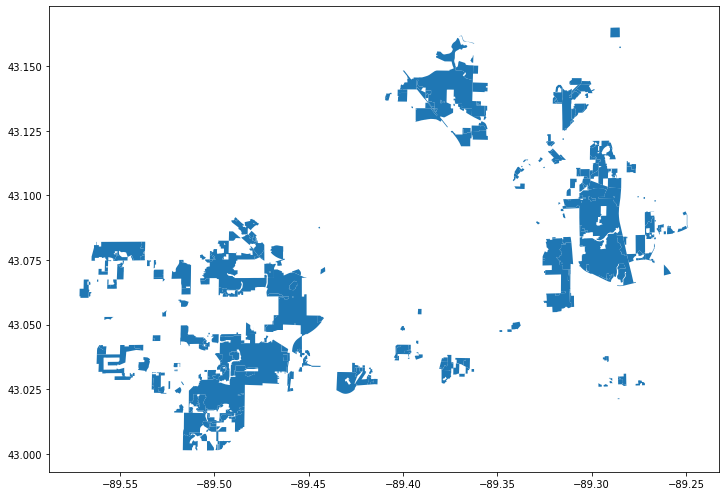

In [8]:
fig, ax = plt.subplots(figsize=(12, 10))
zones[zones["ZONING_COD"].str.startswith("SR")].plot(ax=ax)

In [9]:
trip_ids = [1022598, 1022597, 1022596, 1022595, 1022594, 1022593, 1022592, 1022605, 1022604, 1022603, 1022602, 1022601, 1022600, 1022599]
df = stop_times_df[stop_times_df["trip_id"].isin(trip_ids)]
df[df["stop_id"] == 9196]
df["stop_headsign"].value_counts()

SUN PRAIRIE                            49
CAPITOL SQUARE: VIA PARK & RIDE        48
SUN PRAIRIE: VIA PARK & RIDE           40
SUN PRAIRIE: VIA AMERICAN CENTER       36
CAPITOL SQUARE                         35
CAPITOL SQUARE: VIA AMERICAN CENTER    21
DROP OFFS ONLY                         14
Name: stop_headsign, dtype: int64